In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import getpass
import pymysql
import matplotlib
import geoplot as gplt

In [2]:
password = getpass.getpass()

database = 'geodata'
user = 'root'
host='localhost'

con = pymysql.connect(host=host, user=user, passwd=password, database=database)
cur = con.cursor()
con.autocommit(True)

 ·······


In [3]:
points = pd.read_sql("select code, responsible, water_body, year, count, mean, min, max, stddev, variance, ST_AsText(geometry) as geometry, state_initial from point", con)

points['geometry'] = points['geometry'].apply(wkt.loads)
points_gpd = gpd.GeoDataFrame(points, geometry="geometry")

points.head()
#points_gpd.plot()

,code,responsible,water_body,year,count,mean,min,max,stddev,variance,geometry,state_initial
0,00MS23CH2018,IMASUL,Rio Cachoeirão,2017,6,73.666667,70.6,75.3,2.377113,5.650667,POINT (-55.27222 -20.47750),MS
1,00MS23CN2002,IMASUL,Rio Canastrão,2017,6,70.166667,65.9,72.7,3.324254,11.050667,POINT (-55.11056 -20.64083),MS
2,00MS23MI0602,IMASUL,Rio Miranda,2017,6,71.633333,70.7,73.0,1.081974,1.170667,POINT (-56.12030 -21.48310),MS
3,00MS23MI1292,IMASUL,Rio Miranda,2017,6,63.166667,60.1,67.2,3.262310,10.642667,POINT (-56.39917 -20.24083),MS
4,00MS23MI2000,IMASUL,Rio Miranda,2017,6,70.000000,61.6,75.2,6.567800,43.136000,POINT (-57.33806 -19.42139),MS


,name,geometry,state
0,Aceguá,"POLYGON ((-54.11276 -31.42931, -54.09821 -31.4...",RS
1,Água Santa,"POLYGON ((-52.04263 -28.11703, -52.03489 -28.1...",RS
2,Agudo,"POLYGON ((-53.25560 -29.44736, -53.23478 -29.4...",RS
3,Ajuricaba,"POLYGON ((-53.78588 -28.11270, -53.78654 -28.1...",RS
4,Alecrim,"POLYGON ((-54.78557 -27.57626, -54.77463 -27.5...",RS


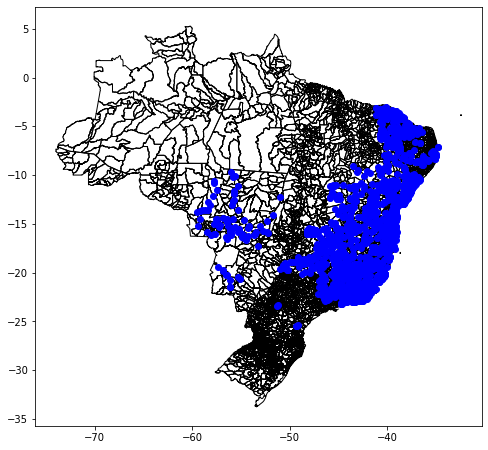

In [23]:
cities = pd.read_sql("select name,ST_AsText(geometry) as geometry,fk_city_state as state from city", con)
cities['geometry'] = cities['geometry'].apply(wkt.loads)
cities_gpd = gpd.GeoDataFrame(cities, geometry="geometry")

ax = cities_gpd.plot(color='none', figsize=(8,8))
points_gpd.plot(color='blue',ax=ax)
cities_gpd.head()

In [ ]:
'''points = points_gpd['geometry']
relations = {}
for index, city in cities_gpd.iterrows():
    cityG = city['geometry']
    cityN = city['name']
    for point in points:
        if(cityG.contains(point)):
           print("aa")
           relations[point] = cityN
print(relations)'''

# Qual estado possui a melhor qualidade média de água (corpos hidrícos)? E qual possui o pior?

In [5]:
grouped_points = points_gpd.groupby(['state_initial']).mean()
grouped_points.sort_values(by=['mean'], ascending = False)

,year,count,mean,min,max,stddev,variance
state_initial,,,,,,,
CE,2017.0,6.189873,71.993940,66.205063,76.839241,4.853529,44.528599
DF,2017.0,8.480000,70.763968,61.485333,78.301333,6.941145,63.840483
RN,2017.0,2.000000,70.438095,70.438095,70.438095,0.000000,0.000000
MS,2017.0,6.000000,68.723333,63.730000,72.590000,4.229418,23.881333
MT,2017.0,4.708861,67.799156,61.983544,73.418987,6.022334,53.197924
BA,2017.0,7.062500,65.749661,58.858854,72.105208,5.820721,47.211372
PE,2017.0,5.571429,65.622817,55.797619,74.114286,8.721586,114.028137
PR,2017.0,2.400000,64.210000,62.640000,65.780000,1.812880,16.432667
MG,2017.0,5.793345,64.055414,56.800000,70.607531,6.760533,69.485126


O estado que possui a melhor qualidade média é o Ceará, com 71.99, já o com o pior é o o Rio de Janeiro, com 48.33 de qualidade média de seus corpos hídricos.

# Distribuição dos corpos hídricos do Ceará e do Rio de Janeiro

In [6]:
ce_points = points_gpd[points_gpd['state_initial']=='CE']
ce_map = cities_gpd[cities_gpd['state']=='CE']
rj_points = points_gpd[points_gpd['state_initial']=='RJ']
rj_map = cities_gpd[cities_gpd['state']=='RJ']

### Gráfico com os corpos hídricos, quanto mais azul, maior a qualidade média do corpo hídrico

<AxesSubplot:>

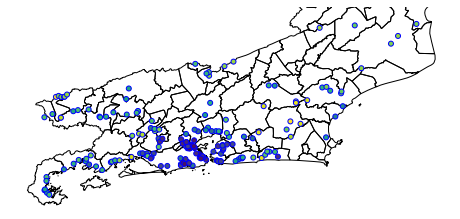

In [15]:
rj_ax = gplt.polyplot(rj_map)
gplt.pointplot(rj_points, ax=rj_ax, hue=rj_points['mean'], edgecolor="blue")

<AxesSubplot:>

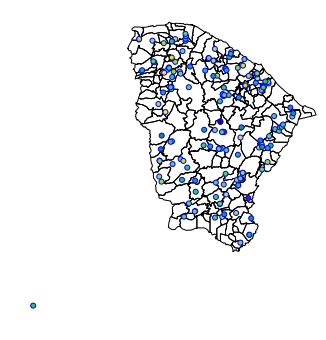

In [16]:
ce_ax = gplt.polyplot(ce_map)
gplt.pointplot(ce_points, ax=ce_ax, hue=ce_points['mean'], edgecolor="blue")